### Demonstrate applying `my-test-set` to `rf-data` trained model

In [1]:
from fastai2.vision.all import *
import time
import copy
import pickle
import sys
sys.path.append('..')

In [2]:
%load_ext autoreload
%autoreload 2

from modules.trainutils import build_dl, piece_class_parse, only_class_parse
from modules.trainutils import stratify_sample

### Load Data: `test_dl` & `train_dl`

In [3]:
test_path = Path('../../../other-chess-data/regulation-pieces-1/crops/')

In [4]:
test_dl = ImageDataLoaders.from_name_func(
                test_path, 
                fnames=get_image_files(test_path),
                valid_pct=0.0, 
                seed=None,
                label_func=piece_class_parse,
                item_tfms=RandomResizedCrop(128, min_scale=0.5),
                batch_tfms=aug_transforms(),
                bs=16,  # there are only 60 samples, this allows full batches
                )

In [5]:
train_path = Path('../../../rf-chess-data/cropped_v1/')

In [6]:
train_seed = 42
train_dl = ImageDataLoaders.from_name_func(
                train_path, 
                fnames=get_image_files(train_path),
                valid_pct=0.2, 
                seed=train_seed,
                label_func=piece_class_parse,
                item_tfms=RandomResizedCrop(128, min_scale=0.5),
                batch_tfms=aug_transforms(),
                )

##### Examine the data
Clearly there is a difference in train set vs test set for photgraphic properties, although piece morphology is the same.
 - White pieces are sepia in color in train but bone-white in test
 - the train has more crisp pieces (due to using a tripod)

In [7]:
len(test_dl.train_ds),  len(test_dl.valid_ds)

(60, 0)

In [8]:
len(train_dl.train_ds),  len(train_dl.valid_ds)

(2296, 574)

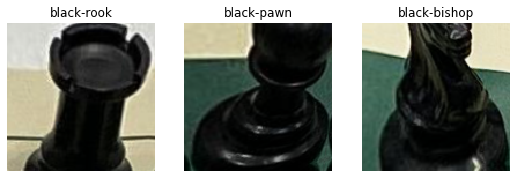

In [9]:
train_dl.show_batch(max_n=3,  nrows=1)

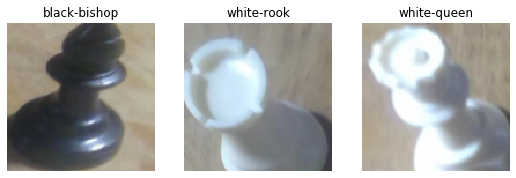

In [10]:
test_dl.show_batch(max_n=3, nrows=1)

### Load Model

In [11]:
!ls ../models -sh

total 146M
48M bing-clean-2.pkl  46M chess1.pkl  53M stadard-piece-2.pkl


In [12]:
learn = load_learner('../models/stadard-piece-2.pkl')

### Apply the normalization to the loaded datasets

In [13]:
fit_norm = learn.dls[1].after_batch[3]

mean, std, axes = fit_norm.mean, fit_norm.std, fit_norm.axes
norm_tfms = Normalize(mean=mean, std=std, axes=axes)

# mean.tolist(),std.tolist(), axes

In [14]:
train_dl.train.after_batch.add(norm_tfms)
# train_dl.valid.after_batch.add(norm_tfms)

In [15]:
test_dl.train.after_batch.add( norm_tfms)

In [16]:
train_dl.valid.after_batch

Pipeline: IntToFloatTensor -> AffineCoordTfm -> LightingTfm -> Normalize

### Interpretation on training + valid data

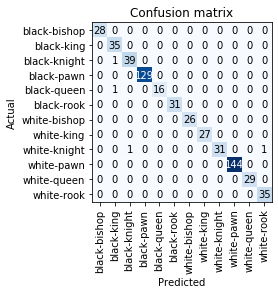

In [17]:
interp_valid = (ClassificationInterpretation
                     .from_learner(
                         learn=learn,
                         dl = train_dl.valid
                     ))
interp_valid.plot_confusion_matrix()

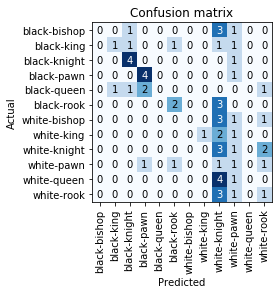

In [19]:
interp_test = (ClassificationInterpretation
                     .from_learner(
                         learn=learn,
                         dl = test_dl.train
                     ))
interp_test.plot_confusion_matrix()

### Get accuracy

In [20]:
from sklearn.metrics import accuracy_score

In [29]:
preds_test = learn.get_preds(dl=test_dl.train, with_loss=True)

In [30]:
len(preds_test)

3

In [59]:
y_actual = preds_test[1].tolist()
y_actual[:4]

[7, 1, 11, 5]

In [43]:
# loss by class
print(learn.loss_func)
learn.loss

FlattenedLoss of CrossEntropyLoss()


tensor([4.2936, 5.7874, 5.6762, 0.6288, 2.1691, 0.3877, 7.5238, 2.1243, 0.2770,
        0.2889, 6.2642, 5.0508])

In [63]:
# roughly the same as the valid_loss from training callback
learn.loss.sum() / len(train_dl.valid.items)

tensor(0.0705)

In [58]:
y_hat = preds_test[0]
y_hat = torch.argmax(y_hat, dim=1)
y_hat = y_hat.tolist()
y_hat[:4]

[7, 1, 9, 9]

In [49]:
accuracy_score(y_actual, y_hat)

0.36666666666666664

In [64]:
loss_test = preds_test[2]
loss_test[:4]

tensor([0.8499, 0.4768, 1.6452, 4.0672])

In [65]:
loss_test.sum() / len(test_dl.train.items)

tensor(2.9380)

### Consolidate accuracy and loss scoring

In [99]:
from sklearn.metrics import accuracy_score

def my_metrics(learn, dl):

    preds_test = learn.get_preds(dl=dl, with_loss=True)

    y_actual = preds_test[1].tolist()
    y_hat = torch.argmax(preds_test[0], dim=1).tolist()
    y_loss = preds_test[2].tolist()

    acc = accuracy_score(y_actual, y_hat)

    loss = sum(y_loss) / len(test_dl.train.items)
    
    return loss, acc

In [100]:
my_metrics(learn, test_dl.train)

(2.9487645398204525, 0.3)

In [101]:
my_metrics(learn, train_dl.train)

(3.452351882712948, 0.98301393728223)

In [102]:
my_metrics(learn, train_dl.valid)

(0.3396239966472283, 0.9930313588850174)

### Consolidate accuracy and loss scoring

### Get multiple folders in one dataloader -> hard

In [93]:
def multi_image_files(train_path, test_path):
    fns = list(get_image_files(train_path))
    fns.extend(get_image_files(test_path))
    return L(fns)

In [ ]:
tt_dl = ImageDataLoaders.from_name_func(
                train_path, 
                fnames=multi_image_files(train_path, test_path)
                valid_pct=0.2, 
                seed=train_seed,
                label_func=piece_class_parse,
                item_tfms=RandomResizedCrop(128, min_scale=0.5),
                batch_tfms=aug_transforms(),
                )

The above looks like (lack of) normalization error where one column gets over-emphasized on prediction, as seen previously with failing to add this transform in hurt the perf on the actual training set.

### Examine the results of the Test Set

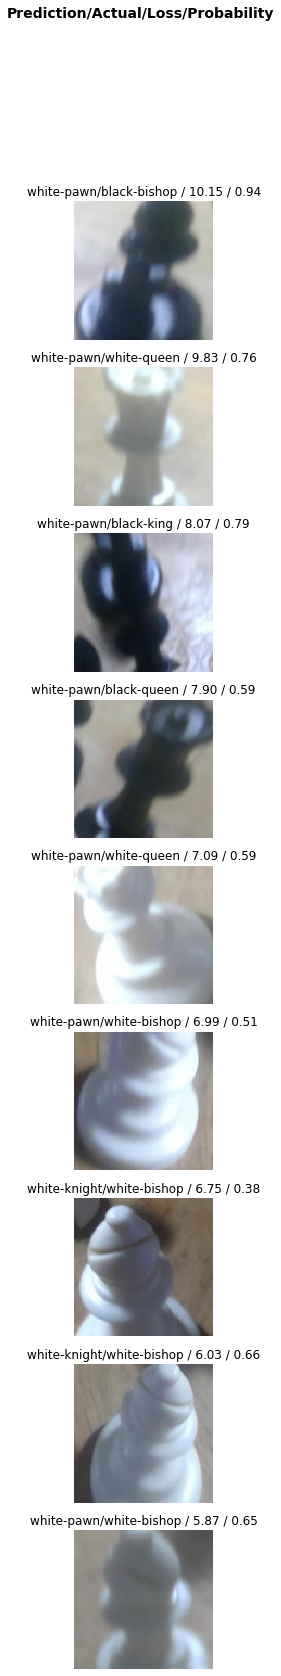

In [108]:
interp_test.plot_top_losses(9, nrows=9)

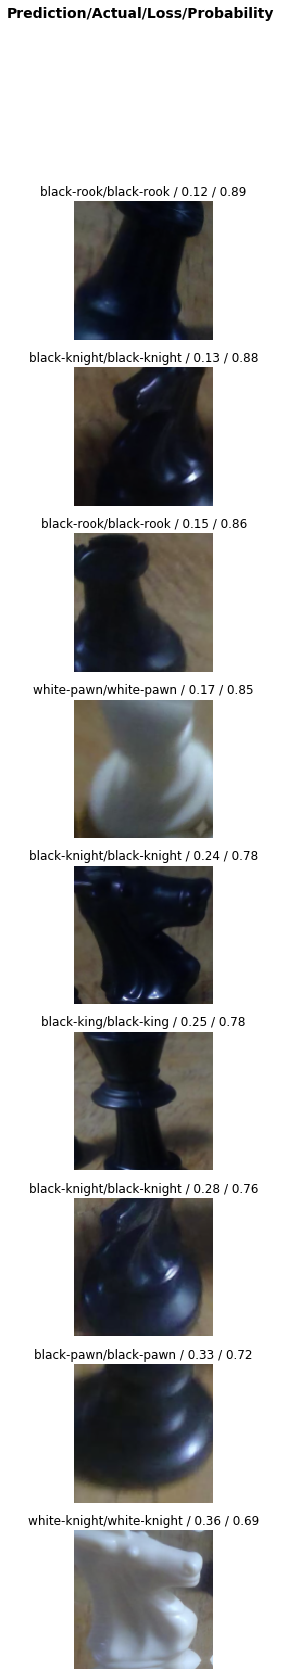

In [106]:
interp_test.plot_top_losses(9, nrows=9, largest=False)

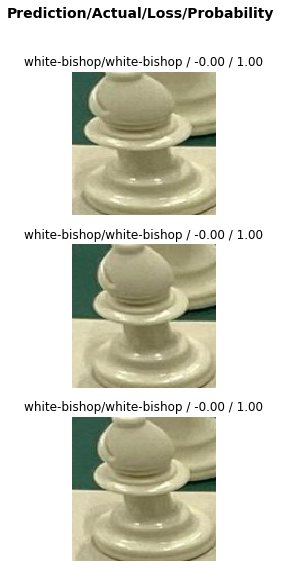

In [110]:
interp_valid.plot_top_losses(3, largest=False, nrows=3)